In [27]:
import warnings
warnings.filterwarnings("ignore")

from abipy import abilab
import abipy.flowtk as flowtk

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline   

# Precision cell relaxation

In [58]:
def gs_input(ecut = 41, acell = 7, rprim = 0.5):
    structure = abilab.Structure.from_abivars(
        ntype = 1,
        znucl = 3,
        natom = 1,
        typat = (1),
        acell = (acell, acell, acell),
        rprim = [
            -rprim, rprim, rprim,
            rprim, -rprim, rprim,
            rprim, rprim, -rprim,
        ],
        xred = [
            0.0, 0.0, 0.0,
        ]
    )
    inp = abilab.AbinitInput(
        structure=structure,
        pseudos="pseudos/Li.psp8"
    )
    # inp = abilab.AbinitInput(
    #     structure=abidata.cif_file("si.cif"),
    #     pseudos=abidata.pseudos("14si.pspnc")
    # )
    inp.set_vars(
        ecut = ecut,
        diemac=10**6,
        # toldfe=1e-8,
        iomode=3,
    )
    inp.set_kmesh(
        ngkpt=(4, 4, 4),     
        shiftk = [
            0.5, 0.5, 0.5,
        ]
    )
    return inp

In [47]:
gsinp = gs_input()
print(gsinp.structure)

Full Formula (Li1)
Reduced Formula: Li
abc   :   3.207966   3.207966   3.207966
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Li      0    0    0


In [57]:
def build_relax_flow():
    inp = gs_input()
    inp.set_vars(
        toldfe=1e-8,
        tolvrs=1e-9,
        optcell=1,
        ionmov=22,
        ntime=10,
        dilatmx=1.1,
        ecutsm=0.5,
        iomode=3,
    )
    inp1 = inp
    inp2 = inp
    inp3 = inp
    inp1.set_kmesh(
        ngkpt=(2, 2, 2),     
        shiftk = [
            0.5, 0.5, 0.5,
        ]
    )
    inp2.set_kmesh(
        ngkpt=(4, 4, 4),     
        shiftk = [
            0.5, 0.5, 0.5,
        ]
    )
    inp3.set_kmesh(
        ngkpt=(6, 6, 6),     
        shiftk = [
            0.5, 0.5, 0.5,
        ]
    )
    workdir = "precision_flow_relax"
    return flowtk.Flow.from_inputs(workdir, inputs=[inp1, inp2, inp3], task_class=flowtk.RelaxTask)

In [49]:
flow_relax = build_relax_flow()
flow_relax.make_scheduler().start()

Using scheduler v >= 3.0.0


[Mon Sep 30 12:56:32 2024] Number of launches: 2

Work #0: <Work, node_id=109, workdir=precision_flow_relax/w0>, Finalized=False
+--------+-----------+------------+--------------+------------+-----------+-----------------+----------+-----------+
| Task   | Status    | Queue      | MPI|Omp|Gb   | Warn|Com   | Class     | Sub|Rest|Corr   | Time     |   Node_ID |
+========+===========+============+==============+============+===========+=================+==========+===========+
| w0_t0  | Submitted | 8907@local | 1|  1|2.0    | 0|  0      | RelaxTask | (1, 0, 0)       | 0:00:00Q |       110 |
+--------+-----------+------------+--------------+------------+-----------+-----------------+----------+-----------+
| w0_t1  | Submitted | 8909@local | 1|  1|2.0    | 0|  0      | RelaxTask | (1, 0, 0)       | 0:00:00Q |       111 |
+--------+-----------+------------+--------------+------------+-----------+-----------------+----------+-----------+
| w0_t2  | Ready     | None       | 1|  1|2.0    | N

0

In [50]:
with abilab.GsrRobot.from_dir("precision_flow_relax") as relax_robot:
    relax_table = relax_robot.get_dataframe().sort_values(by="nkpt")
    relax_table["energy_Ha"] = relax_table["energy"] * abilab.units.eV_to_Ha
    relax_table["a_Br"] = relax_table["a"] * abilab.units.ang_to_bohr
    dfs = relax_robot.get_structure_dataframes()

In [54]:
relax_table[["energy", "energy_Ha", "a", "a_Br", "pressure", "nkpt"]]

,energy,energy_Ha,a,a_Br,pressure,nkpt
w0/t0/outdata/out_GSR.nc,-194.833067,-7.159983,3.367439,6.363537,0.000865,14
w0/t2/outdata/out_GSR.nc,-194.833067,-7.159983,3.367439,6.363537,0.000865,14
w0/t1/outdata/out_GSR.nc,-194.833067,-7.159983,3.367439,6.363537,0.000865,14


# Band structure

In [59]:
def build_ebands_flow():
    
    inp = gs_input(ecut=41, acell=1.0497113188, rprim=3.5)
    
    # Dataset 1
    inp1 = inp
    inp1.set_vars(tolvrs=1e-9)
    inp.set_kmesh(
        ngkpt=(4, 4, 4),     
        shiftk = [
            0.5, 0.5, 0.5,
        ]
    )

    # Dataset 2
    inp2 = inp
    inp2.set_vars(tolwfr=1e-15)
    inp2.set_kpath(ndivsm=5)

    workdir = "precision_flow_ebands"
    return flowtk.bandstructure_flow(workdir, scf_input=inp1, nscf_input=inp2)

In [63]:
def build_ebands_flow():
    structure = abilab.Structure.from_abivars(
        ntype = 1,
        znucl = 3,
        natom = 1,
        typat = (1),
        acell = (1.0497113188,1.0497113188,1.0497113188),
        rprim = [
            -3.5, 3.5, 3.5,
            3.5, -3.5, 3.5,
            3.5, 3.5, -3.5,
        ],
        xred = [
            0.0, 0.0, 0.0,
        ]
    )
    multi = abilab.MultiDataset(
        structure=structure,
        pseudos="pseudos/Li.psp8",
        ndtset=2
    )
    multi.set_vars(
        ecut = 37,
        diemac=10**6,
        iomode=3,
    )
    # Dataset 1
    multi[0].set_vars(tolvrs=1e-9)
    multi[0].set_kmesh(
        ngkpt=(4, 4, 4),     
        shiftk = [
            0.5, 0.5, 0.5,
        ]
    )

    # Dataset 2
    multi[1].set_vars(tolwfr=1e-15)
    multi[1].set_kpath(ndivsm=5)

    scf_input, nscf_input = multi.split_datasets()
    
    workdir = "precision_flow_ebands"
    return flowtk.bandstructure_flow(workdir, scf_input=scf_input, nscf_input=nscf_input)

In [64]:
flow_ebands = build_ebands_flow()
flow_ebands.make_scheduler().start()

Using scheduler v >= 3.0.0


[Mon Sep 30 13:18:50 2024] Number of launches: 1

Work #0: <BandStructureWork, node_id=122, workdir=precision_flow_ebands/w0>, Finalized=False
+--------+-------------+------------+--------------+------------+----------+-----------------+----------+-----------+
| Task   | Status      | Queue      | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time     |   Node_ID |
+========+=============+============+==============+============+==========+=================+==========+===========+
| w0_t0  | Submitted   | 9937@local | 1|  1|2.0    | 0|  0      | ScfTask  | (1, 0, 0)       | 0:00:00Q |       123 |
+--------+-------------+------------+--------------+------------+----------+-----------------+----------+-----------+
| w0_t1  | Initialized | None       | 1|  1|2.0    | NA|NA      | NscfTask | (0, 0, 0)       | None     |       124 |
+--------+-------------+------------+--------------+------------+----------+-----------------+----------+-----------+


nbdbuf is not specified in in

0

In [76]:
with abilab.abiopen("precision_flow_ebands/w0/t1/outdata/out_GSR.nc") as gsr:
    ebands_kpath = gsr.ebands

with abilab.abiopen("precision_flow_ebands/w0/t0/outdata/out_GSR.nc") as gsr:
    ebands_kmesh = gsr.ebands
    
edos = ebands_kmesh.get_edos()

In [77]:
print(ebands_kpath.fermie, edos.fermie)

-47.58808965602596 eV -0.8836686979412283


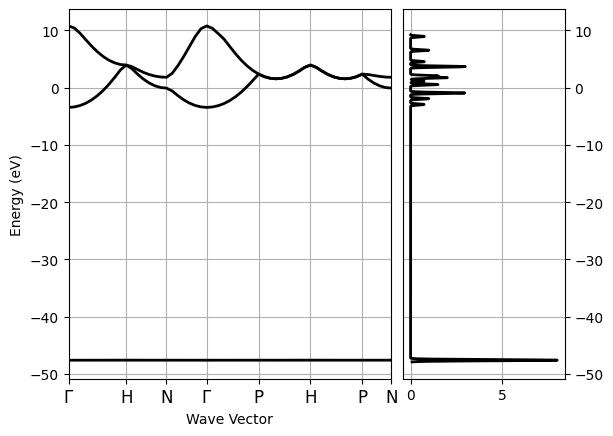

In [78]:
ebands_kpath.plot_with_edos(edos, e0=0);